In [1]:
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import plot_histogram

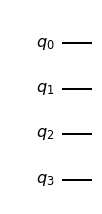

In [2]:
n=3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw(output="mpl")

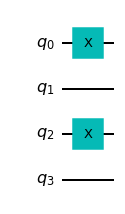

In [3]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.draw(output="mpl") 

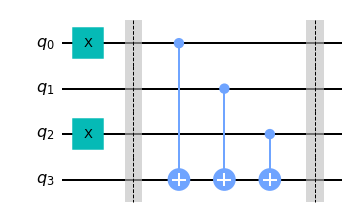

In [4]:
balanced_oracle.barrier()

for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw(output="mpl")

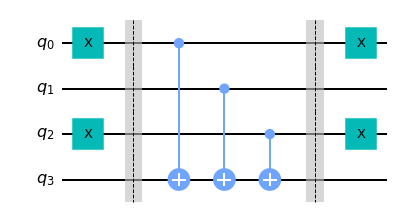

In [5]:
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.draw(output="mpl")        

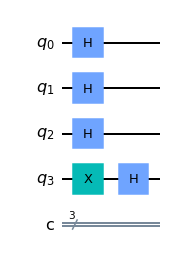

In [6]:
deutsch_jozsa = QuantumCircuit(n+1, n)

for qubit in range(n):
    deutsch_jozsa.h(qubit)

deutsch_jozsa.x(n)
deutsch_jozsa.h(n)
deutsch_jozsa.draw(output="mpl")   

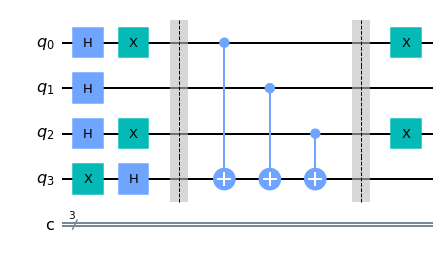

In [7]:
deutsch_jozsa = deutsch_jozsa.compose(balanced_oracle)
deutsch_jozsa.draw(output="mpl")

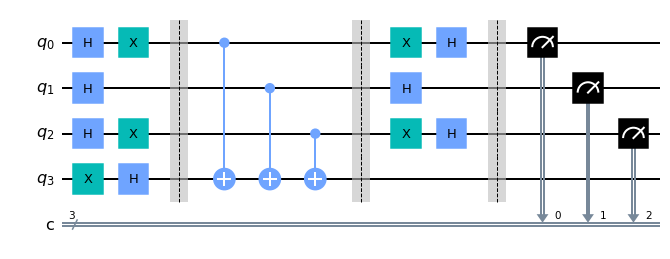

In [8]:
for qubit in range(n):
    deutsch_jozsa.h(qubit)
deutsch_jozsa.barrier()

for i in range(n):
    deutsch_jozsa.measure(i, i)

deutsch_jozsa.draw(output="mpl")    

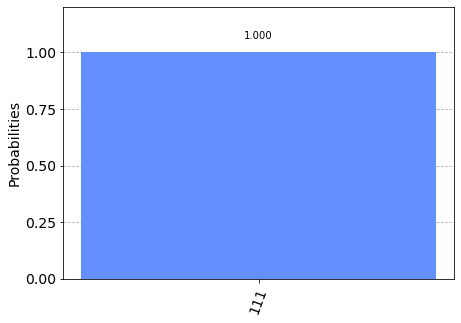

In [9]:
# using Aer
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(deutsch_jozsa).result()
answer = results.get_counts()

plot_histogram(answer)

In [10]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [11]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

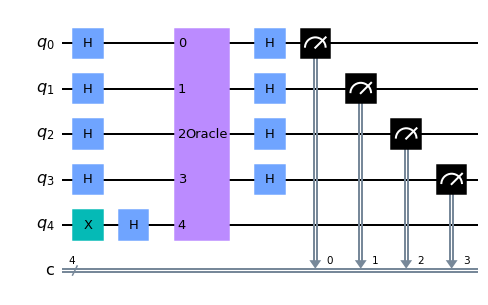

In [12]:
n = 4
oracle_gate = dj_oracle('balanced', n)
deutsch_jozsa = dj_algorithm(oracle_gate, n)
deutsch_jozsa.draw(output='mpl')

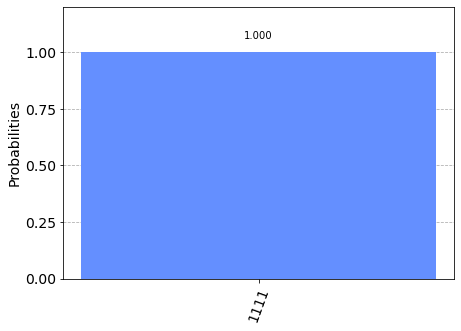

In [13]:
transpiled_dj_circuit = transpile(deutsch_jozsa, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

In [14]:
# using real devices
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_bogota')

In [15]:
from qiskit.tools.monitor import job_monitor
transpiled_dj_circuit = transpile(deutsch_jozsa, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


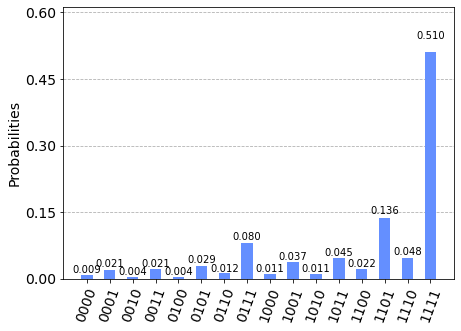

In [16]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
#